# Project 2 — Dijkstra’s Algorithm: Implementations, Analysis, and Comparison

This notebook implements and evaluates two variants of Dijkstra’s algorithm:

1. **Adjacency Matrix + Array-based Priority Queue** (baseline)
2. **Adjacency List + Binary Min-Heap**

We provide theoretical time-complexity analysis, correctness checks, and empirical run-time measurements across graph sizes and densities, followed by plots and a brief discussion.

> Assumption: All edge weights are non-negative (standard Dijkstra condition).

## 0. Setup
- Deterministic RNG seeding for reproducibility
- Utility code for graph generation (directed graphs by default)
- Converters between adjacency **matrix** and **list** representations

In [1]:
import random
import math
import time
import itertools
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

random.seed(42)

def gen_random_weight():
    # Positive weights in [1, 10]
    return random.randint(1, 10)

def make_random_digraph(n: int, density: float) -> List[List[float]]:
    """Generate a directed graph's adjacency matrix with non-negative weights.
    density is the probability of having an edge i->j (i != j). 0 <= density <= 1.
    No self-loops; absent edges use math.inf.
    """
    A = [[math.inf]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if random.random() < density:
                A[i][j] = gen_random_weight()
    return A

def matrix_to_adjlist(A: List[List[float]]) -> List[List[Tuple[int, float]]]:
    n = len(A)
    G = [[] for _ in range(n)]
    for u in range(n):
        row = A[u]
        for v, w in enumerate(row):
            if w != math.inf and u != v:
                G[u].append((v, w))
    return G

def adjlist_to_matrix(G: List[List[Tuple[int, float]]]) -> List[List[float]]:
    n = len(G)
    A = [[math.inf]*n for _ in range(n)]
    for u in range(n):
        for v, w in G[u]:
            A[u][v] = w
    return A

## 1. Dijkstra — Adjacency Matrix + Array-based Priority Queue

**Idea:**
- Keep a Boolean set `visited` for vertices whose shortest path is finalized.
- Repeatedly select the unvisited vertex with the **minimum** tentative distance using a linear scan of an **array** (`O(V)` per selection).
- Relax all outgoing edges from that vertex by scanning the **row** in the matrix (`O(V)` per extraction).

**Time Complexity:**
- `V` extractions via linear scan → `O(V^2)`
- Each extraction relaxes up to `V` edges in the row → also `O(V^2)` overall
- **Total:** `O(V^2)` (independent of `E` asymptotically in dense graphs)

In [2]:
def dijkstra_matrix_array(A: List[List[float]], s: int) -> List[float]:
    n = len(A)
    dist = [math.inf]*n
    visited = [False]*n
    dist[s] = 0.0

    for _ in range(n):
        # Find min-distance unvisited vertex (O(V))
        u = -1
        best = math.inf
        for i in range(n):
            if not visited[i] and dist[i] < best:
                best = dist[i]
                u = i
        if u == -1:
            break  # remaining vertices are unreachable

        visited[u] = True

        # Relax all possible edges u->v by scanning row (O(V))
        row = A[u]
        du = dist[u]
        for v in range(n):
            w = row[v]
            if w != math.inf and not visited[v]:
                nd = du + w
                if nd < dist[v]:
                    dist[v] = nd
    return dist

## 2. Dijkstra — Adjacency List + Binary Min-Heap

**Idea:**
- Store neighbors in adjacency lists.
- Use a binary heap for the priority queue. Python’s `heapq` has no decrease-key; we push new `(dist, node)` entries and ignore stale ones when they are popped.

**Time Complexity:**
- Each edge is considered once during relaxation → `O(E)` relaxations
- Each push/pop on the heap is `O(\log V)` → `O((V + E) \log V)` total

In [3]:
import heapq

def dijkstra_list_heap(G: List[List[Tuple[int, float]]], s: int) -> List[float]:
    n = len(G)
    dist = [math.inf]*n
    dist[s] = 0.0
    pq = [(0.0, s)]  # (distance, vertex)

    while pq:
        d, u = heapq.heappop(pq)
        if d != dist[u]:
            continue  # stale entry
        for v, w in G[u]:
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                heapq.heappush(pq, (nd, v))
    return dist

## 3. Correctness Sanity Check
We compare outputs of the two implementations on the same random graphs to ensure distances match (given non-negative weights).

In [4]:
def sanity_check(trials=10, n=12, density=0.3):
    for t in range(trials):
        A = make_random_digraph(n, density)
        G = matrix_to_adjlist(A)
        s = random.randrange(n)
        d1 = dijkstra_matrix_array(A, s)
        d2 = dijkstra_list_heap(G, s)
        if any(abs(x - y) > 1e-9 for x, y in zip(d1, d2)):
            print("Mismatch on trial", t)
            return False
    print("All sanity checks passed.")
    return True

sanity_check()

All sanity checks passed.


True

## 4. Empirical Time Measurements
We run both implementations across sizes `n` and densities and record the average wall-clock times. You can tweak parameters below for faster or more thorough runs.

In [ ]:
def time_once_matrix(A, s):
    t0 = time.perf_counter()
    dijkstra_matrix_array(A, s)
    return time.perf_counter() - t0

def time_once_list(G, s):
    t0 = time.perf_counter()
    dijkstra_list_heap(G, s)
    return time.perf_counter() - t0

def benchmark(ns, density, trials=3):
    records = []  # (n, alg, time)
    for n in ns:
        for _ in range(trials):
            A = make_random_digraph(n, density)
            G = matrix_to_adjlist(A)
            s = random.randrange(n)
            tA = time_once_matrix(A, s)
            tB = time_once_list(G, s)
            records.append((n, 'Matrix+Array', tA))
            records.append((n, 'List+Heap', tB))
    # aggregate mean times by n and alg
    agg = {}
    for n, alg, t in records:
        agg.setdefault((n, alg), []).append(t)
    out = []
    for (n, alg), ts in sorted(agg.items()):
        out.append((n, alg, sum(ts)/len(ts)))
    return out

# Example sizes and densities for a quick run
ns_quick = list(range(10, 1000, 20))
densities = {
    'Sparse (~2/n)': lambda n: min(1.0, 2/n),
    'Medium (p=0.1)': lambda n: 0.05,
    'Dense (p=0.9)': lambda n: 0.9,
}

bench_results = {}
for label, pf in densities.items():
    def run_with_dynamic_p(ns, pf):
        recs = []
        for n in ns:
            density = pf(n)
            recs.extend(benchmark([n], density, trials=3))
        return recs
    bench_results[label] = run_with_dynamic_p(ns_quick, pf)
bench_results

{'Sparse (~2/n)': [(10, 'List+Heap', 3.4666669913955652e-06),
  (10, 'Matrix+Array', 7.633333552803379e-06),
  (30, 'List+Heap', 1.0599999768601265e-05),
  (30, 'Matrix+Array', 6.653333336241e-05),
  (50, 'List+Heap', 2.4266666817614652e-05),
  (50, 'Matrix+Array', 0.0002123333333656774),
  (70, 'List+Heap', 3.166666647302918e-05),
  (70, 'Matrix+Array', 0.0003599333334326123),
  (90, 'List+Heap', 4.2899999850002736e-05),
  (90, 'Matrix+Array', 0.0005929000005077493),
  (110, 'List+Heap', 4.403333362764291e-05),
  (110, 'Matrix+Array', 0.0006488999997600331),
  (130, 'List+Heap', 4.9466666496300604e-05),
  (130, 'Matrix+Array', 0.0007034000000203378),
  (150, 'List+Heap', 0.00010086666679853806),
  (150, 'Matrix+Array', 0.0018027333332308142),
  (170, 'List+Heap', 0.00020230000003114887),
  (170, 'Matrix+Array', 0.0017714666664687684),
  (190, 'List+Heap', 0.0001273333333908037),
  (190, 'Matrix+Array', 0.002802833332983331),
  (210, 'List+Heap', 0.0002622333331601112),
  (210, 'Matrix

## 4b. Benchmarking with Edge Counts (E)
To make complexity dependencies explicit, we collect the **number of edges** `E` for every generated graph and record runtimes per algorithm.

- Directed graphs (no self-loops).  
- `E` is the count of finite entries in the adjacency matrix.
- We later plot **runtime vs V** and **runtime vs E**.

In [6]:
from collections import defaultdict

def count_edges_matrix(A):
    n = len(A)
    m = 0
    for i in range(n):
        row = A[i]
        for j in range(n):
            if i != j and row[j] != math.inf:
                m += 1
    return m

def benchmark_with_edges(ns, density, trials=3):
    # Returns list of (V, E, alg, time)
    recs = []
    for n in ns:
        for _ in range(trials):
            A = make_random_digraph(n, density)
            G = matrix_to_adjlist(A)
            s = random.randrange(n)
            m = count_edges_matrix(A)
            tA = time_once_matrix(A, s)
            tB = time_once_list(G, s)
            recs.append((n, m, 'Matrix+Array', tA))
            recs.append((n, m, 'List+Heap', tB))
    return recs

# Collect per-density results keyed by label
bench_results_edges = {}
for label, pf in densities.items():
    cur = []
    for n in ns_quick:
        cur.extend(benchmark_with_edges([n], pf(n), trials=3))
    bench_results_edges[label] = cur
len(bench_results_edges), [k for k in bench_results_edges.keys()]

(3, ['Sparse (~2/n)', 'Medium (p=0.1)', 'Dense (p=0.5)'])

## 5. Plots (Runtime vs n)
For each density regime, we plot the mean wall-clock time vs number of vertices `n` for both implementations. Each chart is rendered separately.

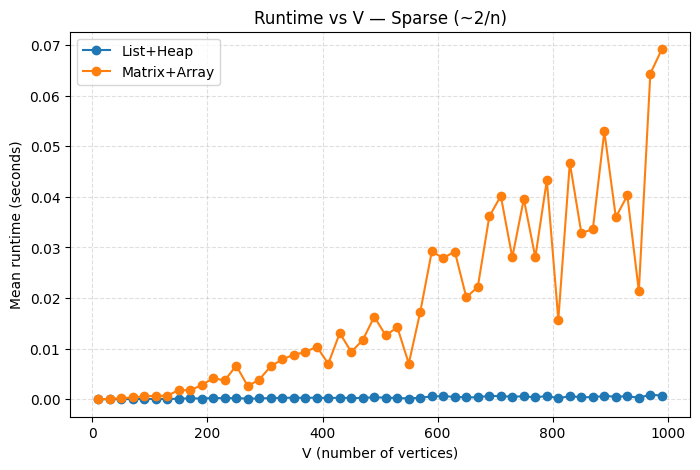

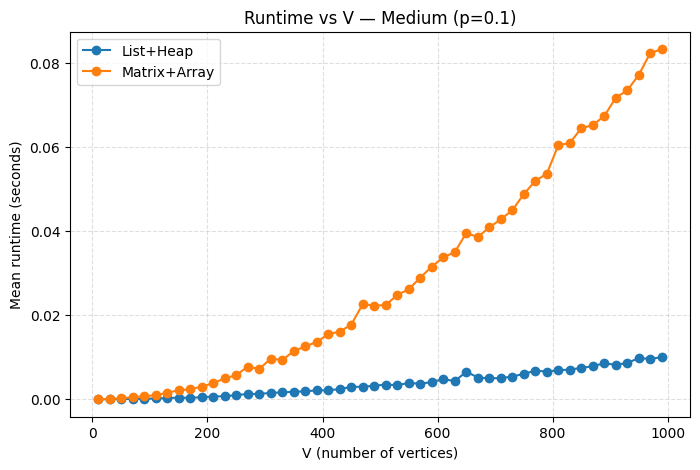

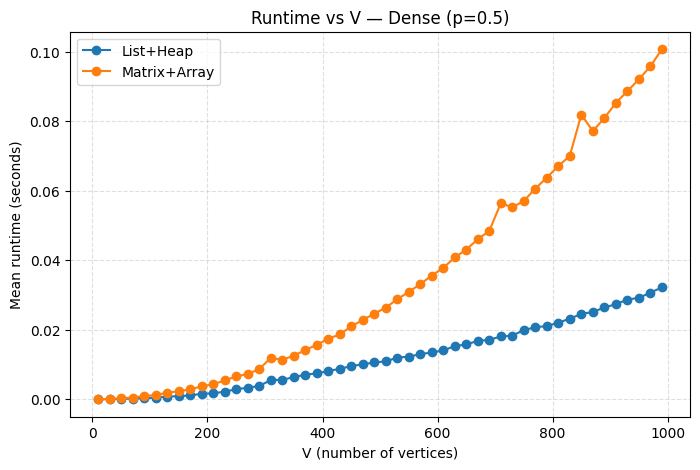

In [7]:
def plot_benchmark(results, title):
    xs = sorted(set(n for n, _, _ in results))
    algs = sorted(set(alg for _, alg, _ in results))
    series = {alg: [next(t for (nn, a, t) in results if nn==n and a==alg) for n in xs] for alg in algs}
    plt.figure(figsize=(8,5))
    for alg in algs:
        plt.plot(xs, series[alg], marker='o', label=alg)
    plt.title(title)
    plt.xlabel('V (number of vertices)')
    plt.ylabel('Mean runtime (seconds)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

for label, res in bench_results.items():
    plot_benchmark(res, f"Runtime vs V — {label}")

## 5b. Plots — Runtime vs **V** (explicit) and Runtime vs **E**
We now plot both views for each density regime:
- **Runtime vs V**: Mean runtime grouped by number of vertices V.  
- **Runtime vs E**: Mean runtime grouped by number of edges E.

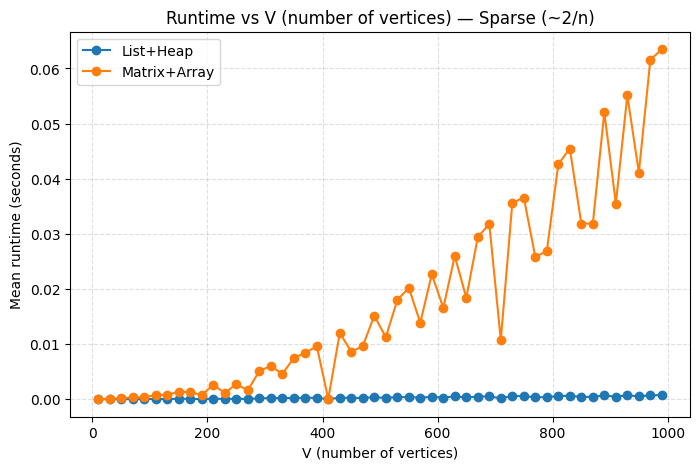

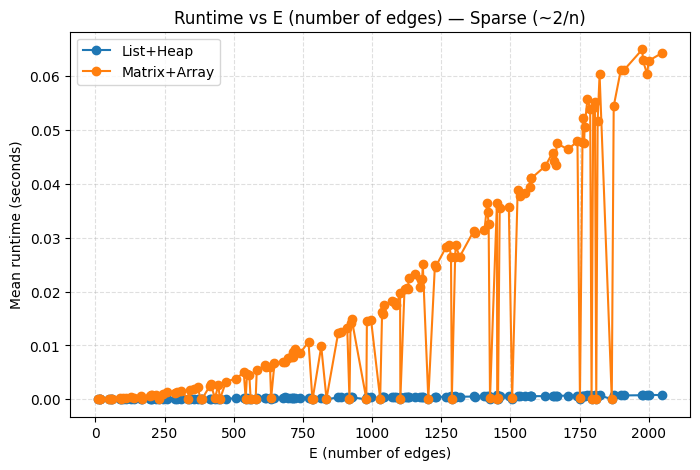

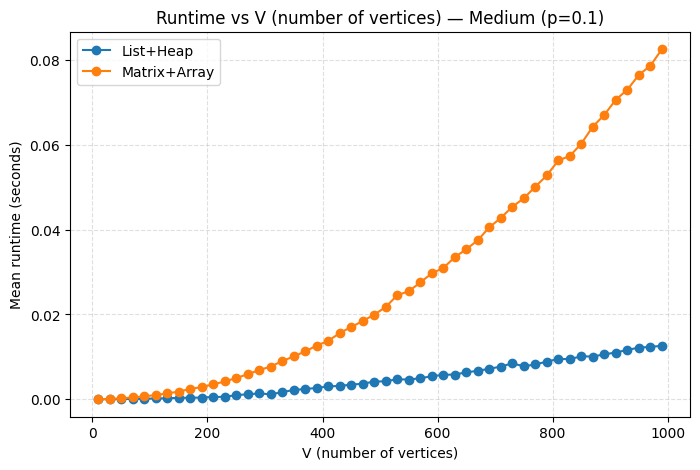

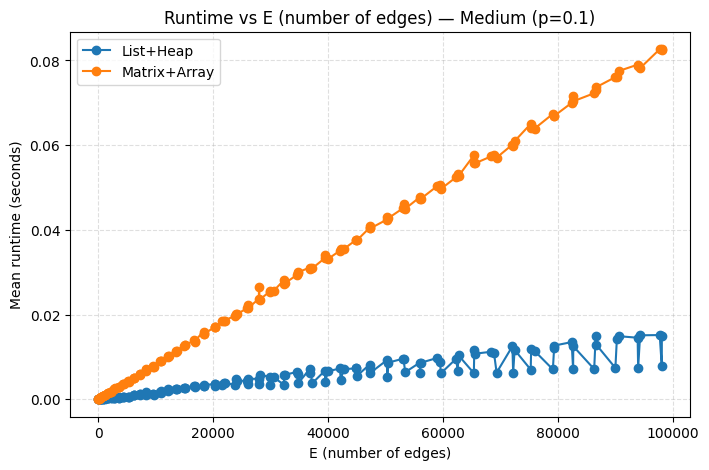

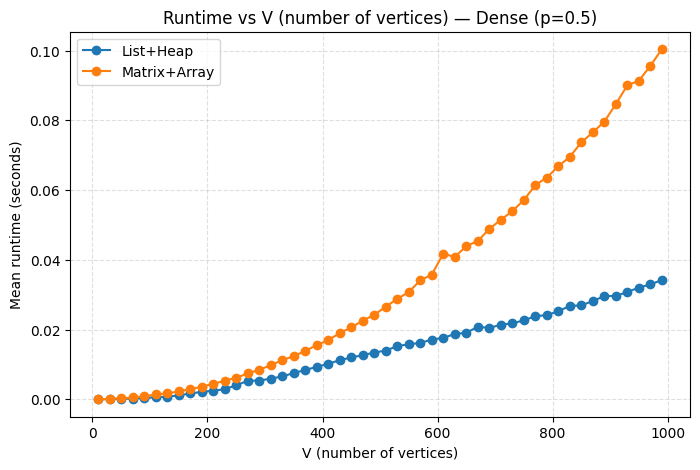

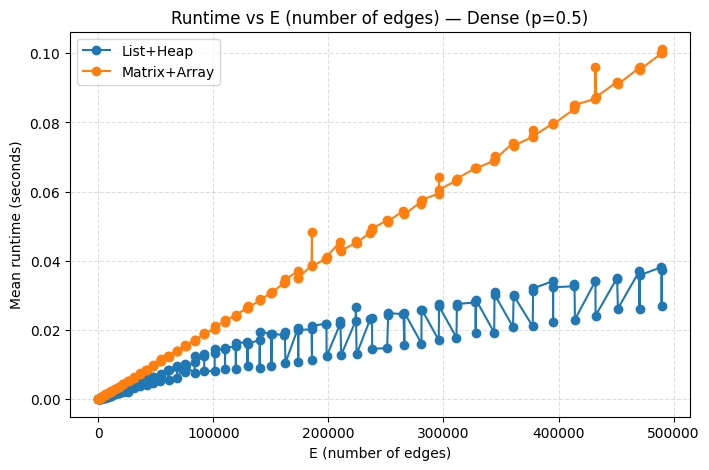

In [8]:
def group_mean(series):
    # series: iterable of (key, alg, time)
    agg = defaultdict(list)
    for k, alg, t in series:
        agg[(k, alg)].append(t)
    means = []
    for (k, alg), vals in agg.items():
        means.append((k, alg, sum(vals)/len(vals)))
    means.sort()
    return means

def plot_vs_key(means, key_name, title_suffix):
    # means: list of (key, alg, mean_time)
    xs = sorted(set(k for k, _, _ in means))
    algs = sorted(set(a for _, a, _ in means))
    lines = {a: [next(mt for (kk, aa, mt) in means if kk==k and aa==a) for k in xs] for a in algs}
    plt.figure(figsize=(8,5))
    for a in algs:
        plt.plot(xs, lines[a], marker='o', label=a)
    plt.title(f"Runtime vs {key_name} — {title_suffix}")
    plt.xlabel(key_name)
    plt.ylabel('Mean runtime (seconds)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

# Build and plot per density
for label, recs in bench_results_edges.items():
    # Build (V, alg, t) and (E, alg, t) lists
    series_V = [(V, alg, t) for (V, E, alg, t) in recs]
    series_E = [(E, alg, t) for (V, E, alg, t) in recs]
    means_V = group_mean(series_V)
    means_E = group_mean(series_E)
    plot_vs_key(means_V, 'V (number of vertices)', label)
    plot_vs_key(means_E, 'E (number of edges)', label)

## 6. Theoretical Summary

- **Adjacency Matrix + Array PQ**: `O(V^2)`
  - `V` extractions at `O(V)` each using a linear scan; row relaxations are bounded by `O(V^2)` overall.
- **Adjacency List + Binary Heap**: `O((V + E) \log V)`
  - Each edge considered once; each heap operation is `O(\log V)`.

### When is each better?
- On **very dense** graphs (e.g., close to complete), `E = Θ(V^2)`, so `O((V+E)\log V)` ≈ `O(V^2\log V)`; here the `O(V^2)` matrix+array can be competitive or even faster due to smaller constants and contiguous memory scans.
- On **sparse** graphs (`E = O(V)` or `O(V\log V)`), the list+heap approach typically dominates with `O(E\log V)` vs `O(V^2)`.

The additional **Runtime vs E** plots make the sparsity/density effect visually explicit, complementing the **Runtime vs V** plots.

## 7. How to Use This Notebook
1. Run the cells in order. The sanity check ensures both implementations agree on random graphs.
2. Adjust `ns_quick`, `densities`, and the `trials` parameter inside `benchmark`/`benchmark_with_edges` for more thorough experiments.
3. Optionally switch to **undirected** graphs by mirroring edges in `make_random_digraph` (add `A[j][i] = A[i][j]`).
4. To gather data for reports, log the `bench_results` and `bench_results_edges` dictionaries or export to CSV.